# Final Project
## Lars Kühmichel, Nicolas Wolf

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path

from fproject_get_data import preprocess_and_save_data, load_and_plot_data

In [2]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

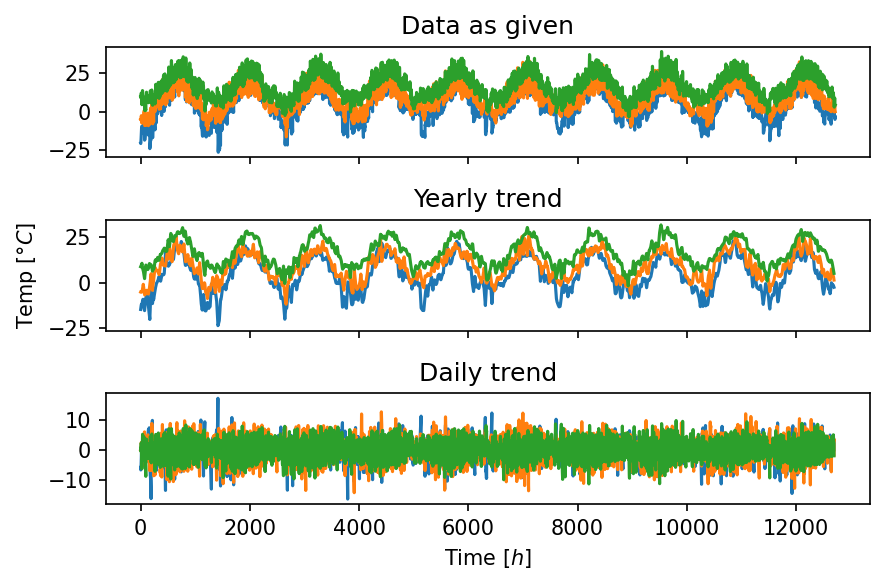

In [3]:
#preprocess_and_save_data()
npa, mnpa = load_and_plot_data()

## 1 Train-test split
First 8 years train set, last 2 years test set

In [4]:
ratio = 0.8
x_train = npa[:int(ratio*len(npa))]
x_test = npa[int(ratio*len(npa)):]

## 2 VAR(1)-model
Linear latent space model with a VAR(1) as latent model
$$
z_{t+1}=Az_t+\epsilon_t,\quad\epsilon_t\sim\mathcal{N}(0,\Sigma),\quad z_0\sim\mathcal{N}(\mu_0,\Sigma)
$$
and a linear observation equation
$$
x_t = Bz_t+\eta_t,\quad\eta_t\sim\mathcal{N}(0,\Gamma)
$$

This model is trained with the Expectation-Maximization-algorithm.

The E-Step consists of the Kalman-Filter-Smoother equation from sheet 6.

The equations for the M-step were derived in the sheets 4 and 5:
$$
\begin{align}
    A &= \left(\sum_{t=2}^T\mathbb{E}[z_t z_{t-1}^T]\right)\cdot\left(\sum_{t=1}^{T-1}\mathbb{E}[z_t z_{t}^T]\right)^{-1}, \\
    \Sigma &= \frac{1}{T} \left( \sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T] - A\cdot\sum_{t=2}^T\mathbb{E}[z_t z_{t-1}^T]^T \right), \\
    \mu_0 &= \mathbb{E}[z], \\
    B &= \left(\sum_{t=2}^Tx_t\mathbb{E}[z_t]^T\right)\cdot\left(\sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T]\right)^{-1}, \\
    \Gamma &= \frac{1}{T} \sum_{t=2}^T \left[ x_tx_t^T - \left(x_t\mathbb{E}[z_z]^TB^T + \left(x_t\mathbb{E}[z_z]^TB^T\right)^T\right) + B\mathbb{E}[z_tz_t^T]B^T \right].
\end{align}
$$
In these equations, $\mathbb{E}[z_t]$ equals to the result of the Kalman-Smoother $\tilde{\mu}$, while $\mathbb{E}[z_tz_t^T]=\mathrm{Var}[z_t] + \mathbb{E}[z_t]\mathbb{E}[z_t]^T=\tilde{V}_t + \mathbb{E}[z_t]\mathbb{E}[z_t]^T$, where $\tilde{V}$ is the result of the Kalman-Smoother. 

In order to get $\mathbb{E}[z_tz_{t-1}^T]$, we calculate
$$
\begin{align}
    \mathrm{Cov}[z_t,z_{t-1}\mid\{x_t\}_{1,...,T}] &= \tilde{V}_tL_{t-1}^{-1}AV_{t-1}, \\
    \mathbb{E}[z_tz_{t-1}^T] &= \mathrm{Cov}[z_t,z_{t-1}\mid\{x_t\}_{1,...,T}] + \mathbb{E}[z_t]\mathbb{E}[z_{t-1}]^T
\end{align}
$$
in the Kalman-Smoother part.

In [25]:
class VAR():
    """Linear VAR(1) with coupled linear observation equation:
        z(t) = A @ z(t-1) + epsilon(t)
        x(t) = B @ z(t) + eta(t)
        z(0) ~ N(mu0, Sigma)
        epsilon(t) ~ N(0, Sigma), eta(t) ~ N(0, Gamma)
    """
    
    def __init__(self, A, Sigma, mu0, B, Gamma):
        self.set_parameters(A, Sigma, mu0, B, Gamma)
        self.latent_dim = Sigma.shape[0]
        self.obs_dim = Gamma.shape[0]
        
    @staticmethod
    def load_from_dict(path):
        """Creates VAR from .npy file containing a dict with the parameters"""
        data = np.load(path, allow_pickle=True)[()]
        return VAR(**data)
        
    def set_parameters(self, A, Sigma, mu0, B, Gamma):
        """Set new model parameters"""
        self.A = A
        self.Sigma = Sigma
        self.mu0 = mu0
        self.B = B
        self.Gamma = Gamma
        
    def get_parameters(self):
        """Returns dict with model parameters"""
        return {
            "A": self.A,
            "Sigma": self.Sigma,
            "mu0": self.mu0,
            "B": self.B,
            "Gamma": self.Gamma
        }
        
    def generate_time_series(self, T, mu0=None):
        """Generates a time series starting from mu0
        
        Args:
            T: length of time series
            mu0: If None: Use estimated mu0, i.e. start from beginning
                Else: Sample z0 with given mu0
            
        Returns:
            The tuple (z, x) containing the latent space time 
            series z of shape (T, latent_dim) and the
            observed time series x of shape (T, obs_dim)
        """
        z = np.zeros(shape=(T, self.latent_dim))
        x = np.zeros(shape=(T, self.obs_dim))
        
        # Noise for the latent space transition equation
        epsilon = np.random.multivariate_normal(np.zeros(self.latent_dim), self.Sigma, size=T)
        # Nosie for the observation equation
        eta = np.random.multivariate_normal(np.zeros(self.obs_dim), self.Gamma, size=T)

        # sample z0 using the estimated mu0 or the given mu0
        if mu0 is None:
            z[0] = np.random.multivariate_normal(self.mu0, self.Sigma)
        else:
            z[0] = np.random.multivariate_normal(mu0, self.Sigma)
            
        # Calculate first observed value from the sampled z0
        x[0] = self.B @ z[0] + eta[0]
        
        # iterate over the remaining time steps
        for t in range(1, T):
            z[t] = self.A @ z[t-1] + epsilon[t]
            x[t] = self.B @ z[t] + eta[t]
            
        return z, x
    
    
    
    def estimate_parameters(self, x, E_z, E_zz, E_zz1):
        """Performs the M-Step of the Expectation-Maximization algorithm as given above
        
        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_zz1 = (E[z_t @ z_{t-1}^T])_t: of shape (T-1, latent_dim, latent_dim)

        Returns:
            Tuple with new estimates of the model parameters in the same order as in __init__, i.e.
            (A, Sigma, mu0, B, Gamma)
        """
        T = len(x)
        
        # Use np.linalg.solve instead of np.linalg.inv for better precision
        # X = B * A^-1  <=>  X * A = B  <=>  A^T * X^T = B^T
        # => X = solve(A^T, B^T)^T
        #A_new = np.sum(E_zz1, axis=0) @ np.linalg.inv(np.sum(E_zz[:-1], axis=0))
        A_new = np.linalg.solve(np.sum(E_zz[:-1], axis=0).T, np.sum(E_zz1, axis=0).T).T
        
        Sigma_new = 1/T * (np.sum(E_zz[1:], axis=0) - A_new @ np.sum(E_zz1, axis=0).T)
        # Make Sigma diagonal. Otherwise it wouldn't necessarily be positive semi-definite
        Sigma_new = np.diag(np.diag(Sigma_new))
        
        mu0_new = E_z[0]
        
        sum_t_x_Ez = np.einsum("ij,il->jl", x, E_z)
        
        #B_new = sum_t_x_Ez @ np.linalg.inv(np.sum(E_zz, axis=0))
        B_new = np.linalg.solve(np.sum(E_zz, axis=0).T, sum_t_x_Ez.T).T
        
        sum_t_x_Ez_BT = sum_t_x_Ez @ B_new.T
        Gamma_new = 1/T * (np.einsum("ij,il->jl", x, x) - sum_t_x_Ez_BT - sum_t_x_Ez_BT.T + B_new @ np.sum(E_zz, axis=0) @ B_new.T)
        # Make Gamma diagonal. Otherwise it wouldn't necessarily be positive semi-definite
        Gamma_new = np.diag(np.diag(Gamma_new))
        
        return A_new, Sigma_new, mu0_new, B_new, Gamma_new
    
    def expected_log_likelihood(self, x, E_z, E_zz, E_zz1):
        """Calculates the expected log-likelihood of this model
        
        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_zz1 = (E[z_t @ z_{t-1}^T])_t: of shape (T-1, latent_idm, latent_dim)
            
        Returns:
            The expected log-likelihood
        """
        Sigma_inv = np.linalg.inv(self.Sigma)
        Gamma_inv = np.linalg.inv(self.Gamma)
        T = len(x)
        
        ell = T*np.linalg.slogdet(self.Sigma)[1] + T*np.linalg.slogdet(self.Gamma)[1]
        ell += np.trace(Sigma_inv @ E_zz[1:], axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.A.T @ Sigma_inv @ E_zz1, axis1=1, axis2=2).sum()
        ell += np.trace(self.A.T @ Sigma_inv @ self.A @ E_zz[:-1], axis1=1, axis2=2).sum()
        
        ell += np.trace(Gamma_inv @ np.einsum("ij,il->ijl", x, x), axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.B.T @ Gamma_inv @ np.einsum("ij,il->ijl", x, E_z), axis1=1, axis2=2).sum()
        ell += np.trace(self.B.T @ Gamma_inv @ self.B @ E_zz, axis1=1, axis2=2).sum()
        
        return -ell / 2.

In [6]:
def Kalman_Filter_Smoother(x, A, Sigma, mu0, B, Gamma, L0):
    """Performs E-Step using the Kalman-Filter-Smoother equation
    
    Args:
        x: observed time series of shape (T, obs_dim)
        (A, Sigma, mu0, B, Gamma): Parameter of the model
        L0: initial condition for the covariance matrix.
        
    Returns:
        mu: estimated means of the Filter-part of shape (T, latent_dim)
        V: estimated covariances of the Filter-part of shape (T, latent_dim, latent_dim)
        mu_tilde: estimated means of the Smoother-part of shape (T, latent_dim)
        V_tilde: estimated covariances of the Smoother-part of shape (T, latent_dim, latent_dim)
        V_tt1: estimated covariances with time lag, i.e. cov[z_t, z_{t-1}] of the Smoother-part of shape (T, latent_dim, latent_dim)
    """
    # Initialize all variables
    p = Sigma.shape[0]
    q = Gamma.shape[0]
    T = len(x)
    K = np.zeros(shape=(T, p, q))
    L = np.zeros(shape=(T, p, p))
    mu = np.zeros(shape=(T, len(mu0)))
    V = np.zeros(shape=(T, p, p))
    mu_tilde = np.zeros(shape=mu.shape)
    V_tilde = np.zeros(shape=V.shape)
    V_tt1 = np.zeros(shape=V.shape) # = cov_theta[z_t,z_{t-1} | {x_t}_{t=1...T}]
    
    
    # Kalman Filter
    
    # First step using initial conditions
    # Use solve instead of inv for higher precision 
    # K[0] = L0 @ B.T @ np.linalg.inv((B @ L0 @ B.T + Gamma))
    K[0] = np.linalg.solve((B @ L0 @ B.T + Gamma).T, (L0 @ B.T).T).T
    V[0] = (np.eye(p) - K[0] @ B) @ L0
    L[0] = L0
    mu[0] = mu0 + K[0] @ (x[0] - B @ mu0)
    
    # loop over the remaining time steps
    for t in range(1, T):
        L[t] = A @ V[t-1] @ A.T + Sigma
        #K[t] = L[t] @ B.T @ np.linalg.inv((B @ L[t] @ B.T + Gamma))
        K[t] = np.linalg.solve((B @ L[t] @ B.T + Gamma).T, (L[t] @ B.T).T).T
        mu[t] = A @ mu[t-1] + K[t] @ (x[t] - B @ A @ mu[t-1])
        V[t] = (np.eye(p) - K[t] @ B) @ L[t]
        
        
    # Kalman Smoother
    
    # first value in the smoother step equals the last value of the filter step
    mu_tilde[-1] = mu[-1]
    V_tilde[-1] = V[-1]
    
    for t in range(T-2, -1, -1):
        #J = V[t] @ A.T @ np.linalg.inv(L[t])
        J = np.linalg.solve(L[t+1].T, (V[t] @ A.T).T).T
        V_tilde[t] = V[t] + J @ (V_tilde[t+1] - L[t+1]) @ J.T
        mu_tilde[t] = mu[t] + J @ (mu_tilde[t+1] - A @ mu[t])
        V_tt1[t+1] = V_tilde[t+1] @ J.T
    
    return mu, V, mu_tilde, V_tilde, V_tt1

In [7]:
def Expectation_Maximization(var, x, expected_log_likelihoods, parameter_differences, parameters, MSE_train, MSE_test, max_iter=100, tol=1e-4, path=None):
    """Performs the Expectation-Maximization algorithm
    
    Args:
        var: the linear latent space model with linear observation equation
        x: observed time series of shape (T, obs_dim)
        expected_log_likelihoods: List to which the calculated expected log likelihood is appended each iteration
        parameter_differences: This function calculates the maximal absolute parameter difference compared to the previous iteration
        parameters: List of the parameters of each iteration combined into a dict as returned by var.get_parameters()
        MSE_train, MSE_test: Every 10th iteration 10 time series are sampled and calculated with the current model state
            and the averaged mean squared errors for the train and the test set are appended
        max_iter: maximum number of iterations
        path: If None: Save the lists above-mentioned lists to the given folder
    
    Returns:
        the new VAR model
    """
    ell_prev = 0
    pbar = tqdm(range(max_iter))
    pbar.set_description(f"latent_dim = {var.latent_dim}, iteration {0}")
    train_error = 0
    test_error = 0
    
    for i in pbar:
        old_params = var.get_parameters()
        # Perform Kalman-Filter-Smoother algorithm using the current parameters
        mu, V, mu_tilde, V_tilde, V_tt1 = Kalman_Filter_Smoother(x=x, L0=var.Sigma, **old_params)
        
        # Calculate expectations using the results from the Kalman-Smoother
        E_z = mu_tilde
        E_zz = V_tilde + np.einsum("ij,il->ijl", E_z, E_z)
        E_zz1 = V_tt1[1:] + np.einsum("ij,il->ijl", E_z[1:], E_z[:-1])
        
        # Calculate the new parameters using the expectations and the observed time series
        new_params = var.estimate_parameters(x, E_z, E_zz, E_zz1)
        var.set_parameters(*new_params)

        # Calculate the new expected-log-likelihood
        ell = var.expected_log_likelihood(x, E_z, E_zz, E_zz1)
        
        # Calculate the maximum absolute parameter difference
        max_parameter_difference = max([np.max(np.abs(new_p - old_p)) for (new_p, old_p) in zip(new_params, old_params.values())])
        
        
        # Every 10th iteration (only every 10th for higher speed),
        # generate 10 time series and calculate the averaged MSE-error for the
        # training set and the test set. Since the predictions depend heavily on the sampled z0,
        # we calculate 10 time series and average over those.
        if (i+1) % 10 == 0:
            generated_time_series = np.array([var.generate_time_series(len(npa))[1] for _ in range(10)])
            generated_time_series_train = generated_time_series[:, :len(x_train), :]
            generated_time_series_test = generated_time_series[:, len(x_train):, :]
            train_error = ((generated_time_series_train - x_train[np.newaxis,:,:])**2).mean()
            test_error = ((generated_time_series_test - x_test[np.newaxis,:,:])**2).mean()
            MSE_train.append(train_error)
            MSE_test.append(test_error)

            
        pbar.set_description(f"latent_dim = {var.latent_dim}, iteration {i+1}, ell = {ell:.{int(-np.log10(tol))}f}, max param difference = {max_parameter_difference:.{int(-np.log10(tol))}f}, MSE_train = {train_error:.4f}, MSE_test = {test_error:.4f}")
            
        # append new parameters, expected-log-likelihood and parameter differences to the given lists
        parameters.append(var.get_parameters())
        expected_log_likelihoods.append(ell)
        parameter_differences.append(max_parameter_difference)
        
        
        ell_prev = ell
        
        # Save the parameters and lists (but only every 10th iteration for higher speed)
        if path is not None and i % 10 == 0 and i > 0:
            np.save(path + "A_params.npy", np.array([p["A"] for p in parameters]))
            np.save(path + "Sigma_params.npy", np.array([p["Sigma"] for p in parameters]))
            np.save(path + "mu0_params.npy", np.array([p["mu0"] for p in parameters]))
            np.save(path + "B_params.npy", np.array([p["B"] for p in parameters]))
            np.save(path + "Gamma_params.npy", np.array([p["Gamma"] for p in parameters]))
            np.save(path + "expected_log_likelihoods.npy", expected_log_likelihoods)
            np.save(path + "parameter_differences.npy", parameter_differences)
            np.save(path + "MSE_train.npy", MSE_train)
            np.save(path + "MSE_test.npy", MSE_test)
            
        
    return var

Do a hyperparameter search on the latent dimension:

In [8]:
def find_optimal_latent_dim(latent_dims, continue_training, max_iter):
    """Trains a VAR for multiple latent dimensions and saves parameters, expected_log_likelihoods,
    parameter_differences, MSE_train and MSE_test
    
    Args:
        latent_dims: List containing the latent dimensions for which a VAR should be trained
        continue_training: loads the parameters from the previously trained model and continues training
        max_iter: maximum number of iteration
    """
    T, obs_dim = x_train.shape
    for latent_dim in latent_dims:
        if continue_training:
            # load parameters and other lists to continue training
            A_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy"))
            Sigma_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy"))
            mu0_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy"))
            B_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy"))
            Gamma_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy"))
            expected_log_likelihoods = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy"))
            parameter_differences = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy"))
            MSE_train = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy"))
            MSE_test = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy"))

            # convert 5 arrays of parameters to list of dict of parameters
            parameters = [
                {
                    "A": A,
                    "Sigma": Sigma,
                    "mu0": mu0,
                    "B": B,
                    "Gamma": Gamma
                }
                for (A, Sigma, mu0, B, Gamma) in zip(A_params, Sigma_params, mu0_params, B_params, Gamma_params)
            ]
            
            # MSE_train and MSE_test is only saved every 10th iteration
            # Therefore round down to nearest ten and redo the iteration steps
            index = len(MSE_train) * 10
            parameters = parameters[:index]
            expected_log_likelihoods = expected_log_likelihoods[:index]
            parameter_differences = parameter_differences[:index]

            var = VAR(**parameters[-1])
        
        else:
            # create (new) folder for the parameters and lists
            Path(f"./var_params/latent_dim_{latent_dim:03d}").mkdir(parents=True, exist_ok=True)

            # Initialize parameters.
            # All parameters are chosen small in order to avoid overflows during the first iterations
            # A_initial is chosen as identity + noise, Sigma and Gamma are diagonal with small positive values
            A_initial = np.eye(latent_dim)*1e-2 + np.random.uniform(-1e-3, 1e-3, size=(latent_dim, latent_dim))
            Sigma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=latent_dim))
            mu0_initial = np.random.uniform(-1e-3, 1e-3, size=latent_dim)
            B_initial = np.random.uniform(-1e-3, 1e-3, size=(obs_dim, latent_dim))
            Gamma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=obs_dim))

            var = VAR(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial)

            expected_log_likelihoods = []
            parameter_differences = []
            parameters = []
            MSE_train = []
            MSE_test = []
            
        # train the VAR with Expectation-Maximization
        var = Expectation_Maximization(var, x_train, expected_log_likelihoods, parameter_differences, parameters, MSE_train, MSE_test, max_iter=max_iter, path=f"./var_params/latent_dim_{latent_dim:03d}/")
        
        # convert list of dicts to 5 lists of parameters
        A_params = np.array([p["A"] for p in parameters])
        Sigma_params = np.array([p["Sigma"] for p in parameters])
        mu0_params = np.array([p["mu0"] for p in parameters])
        B_params = np.array([p["B"] for p in parameters])
        Gamma_params = np.array([p["Gamma"] for p in parameters])

        # save parameters and other lists
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy", A_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy", Sigma_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy", mu0_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy", B_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy", Gamma_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy", expected_log_likelihoods)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy", parameter_differences)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy", MSE_train)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy", MSE_test)

In [61]:
find_optimal_latent_dim([4, 8, 16, 32, 64], False, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

MemoryError: Unable to allocate 318. MiB for an array with shape (10176, 64, 64) and data type float64

In [13]:
find_optimal_latent_dim([64], True, 160)

9840


  0%|          | 0/160 [00:00<?, ?it/s]

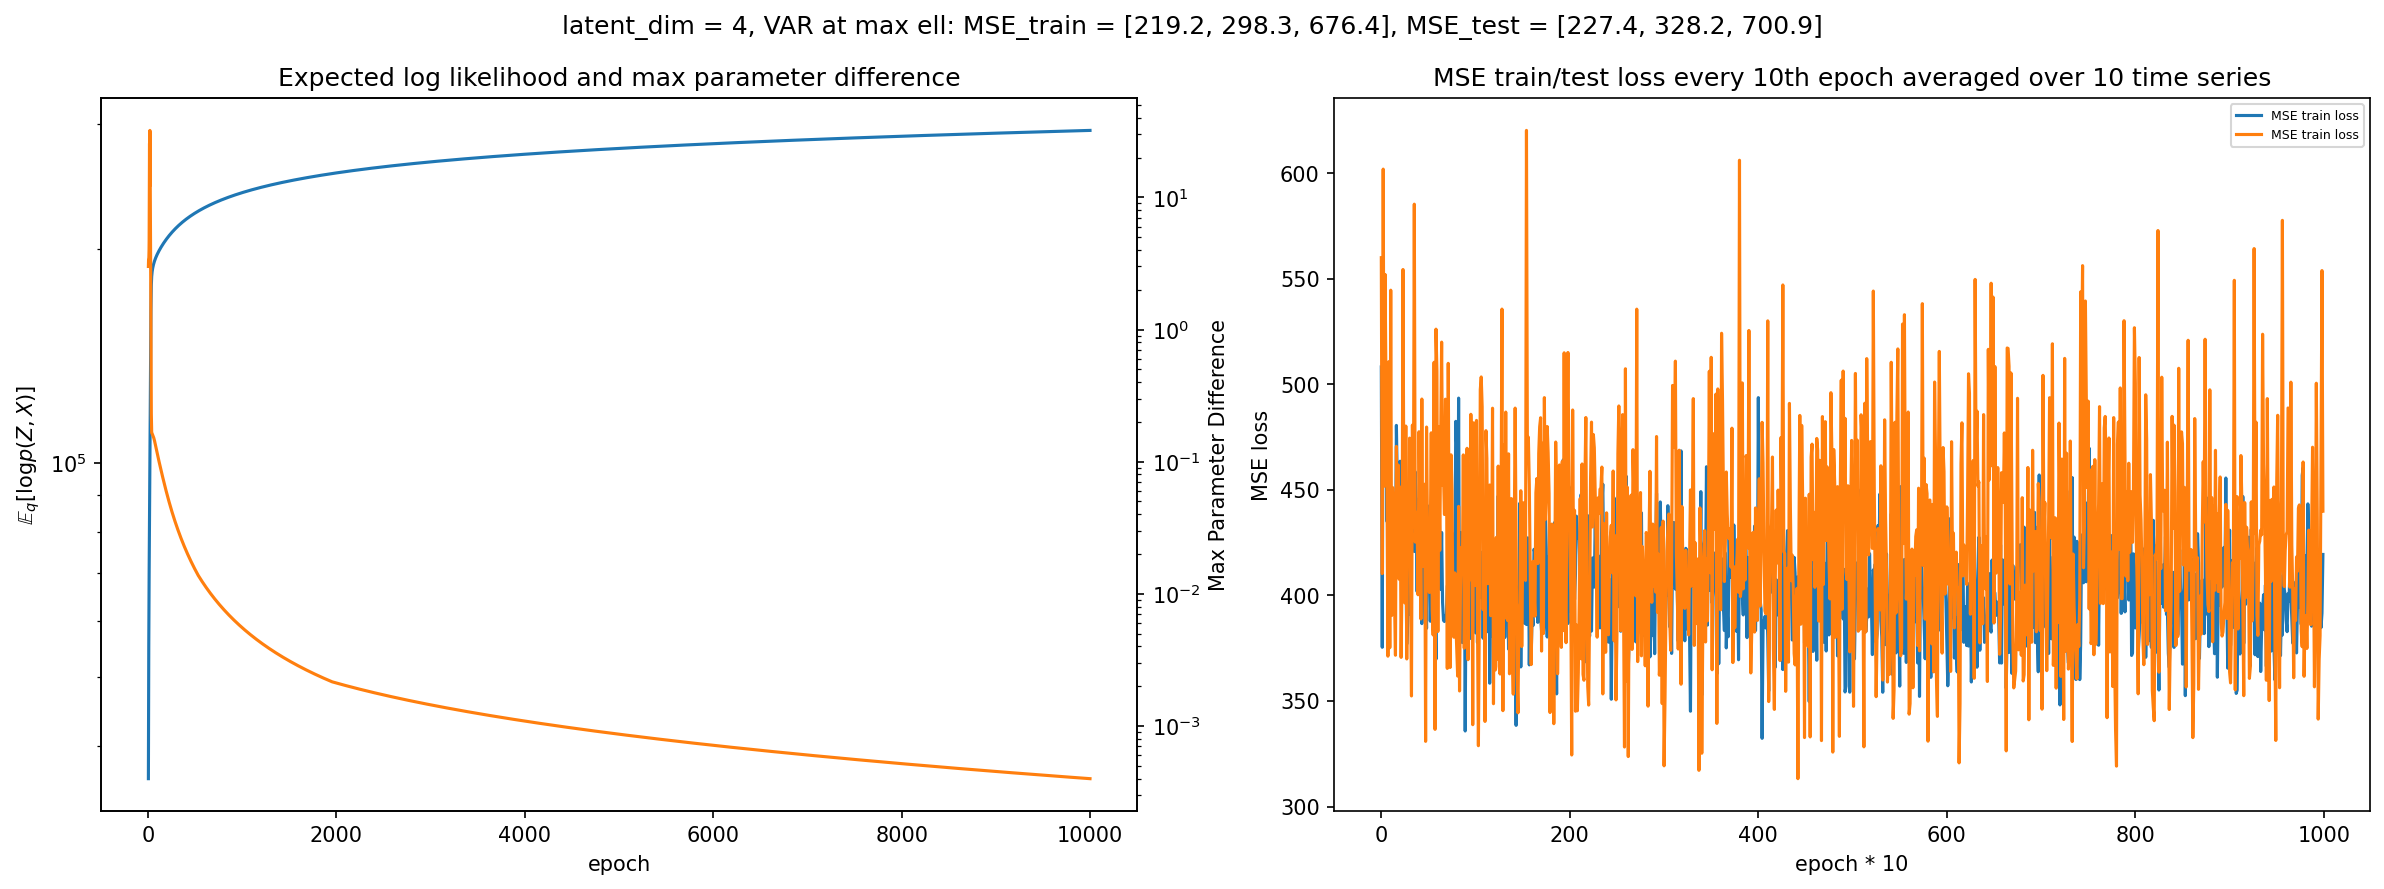

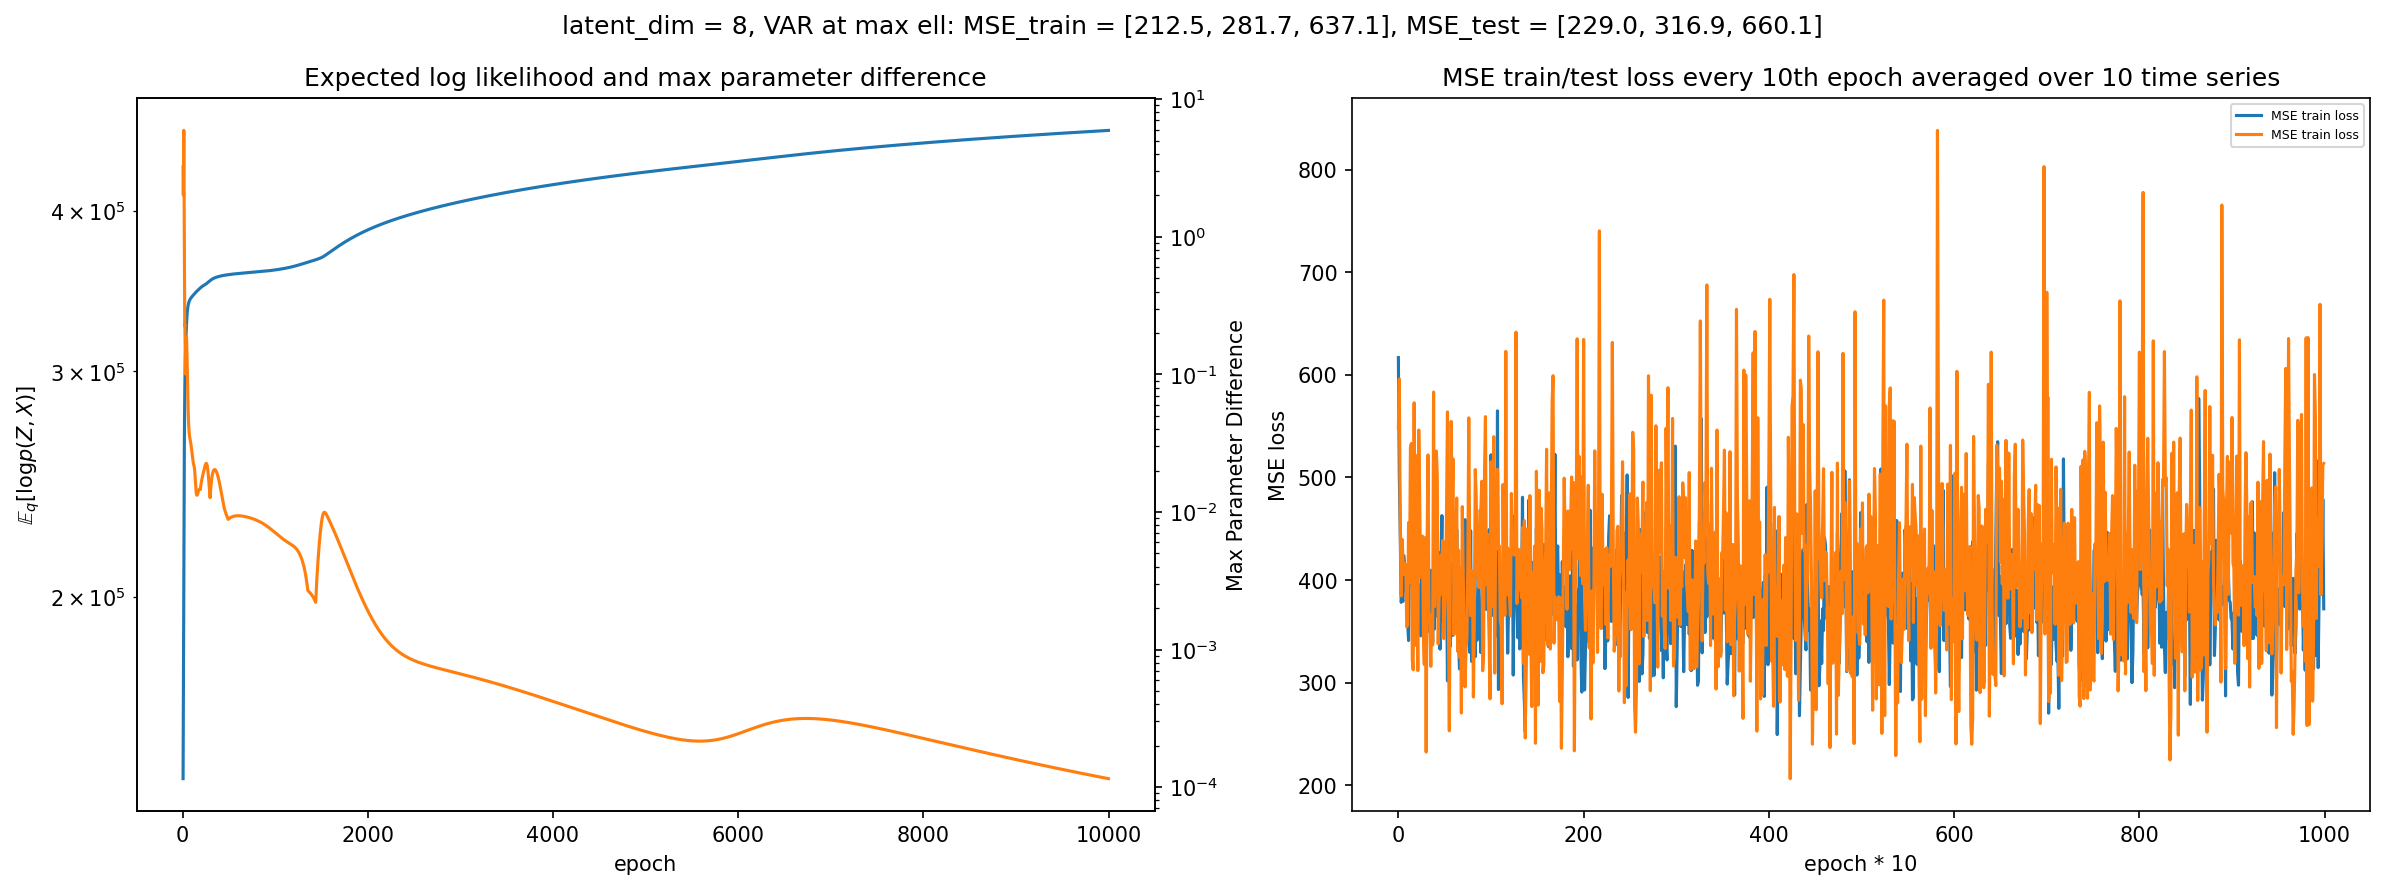

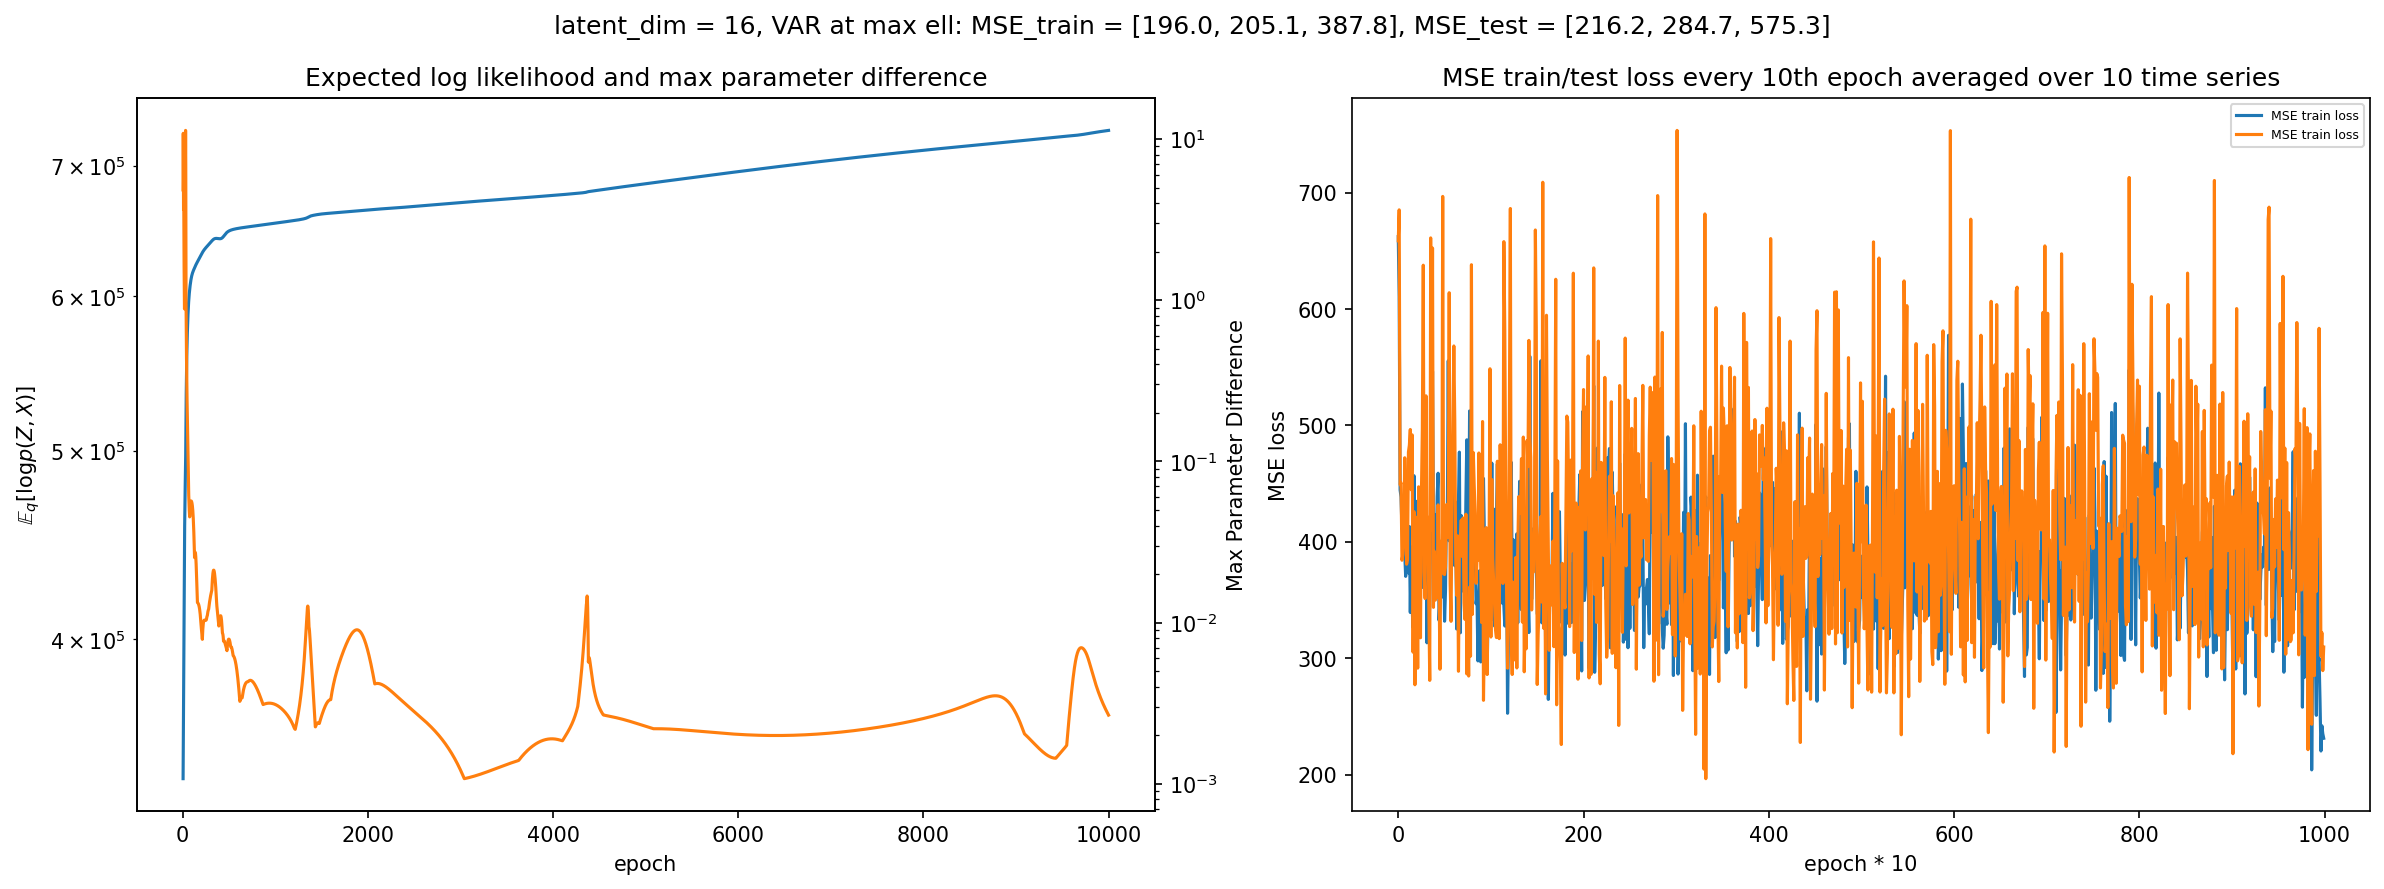

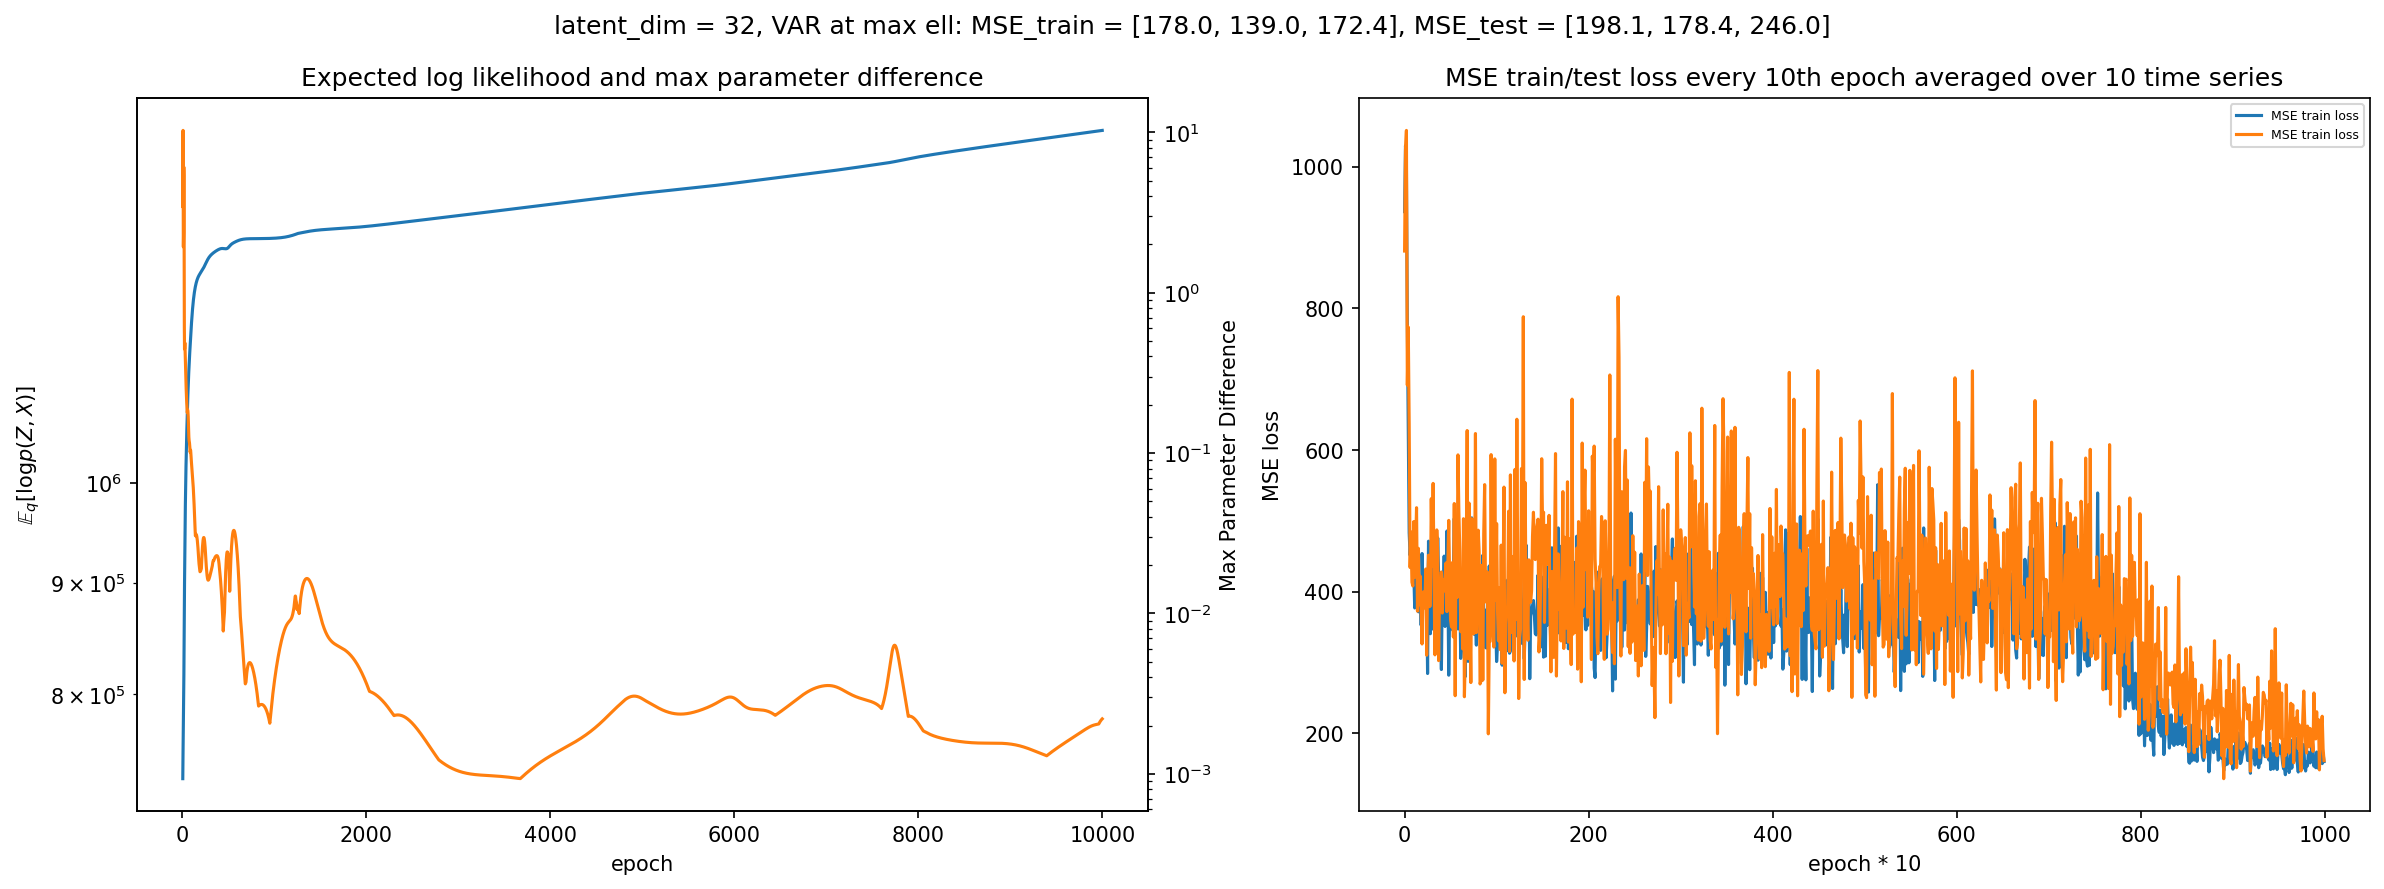

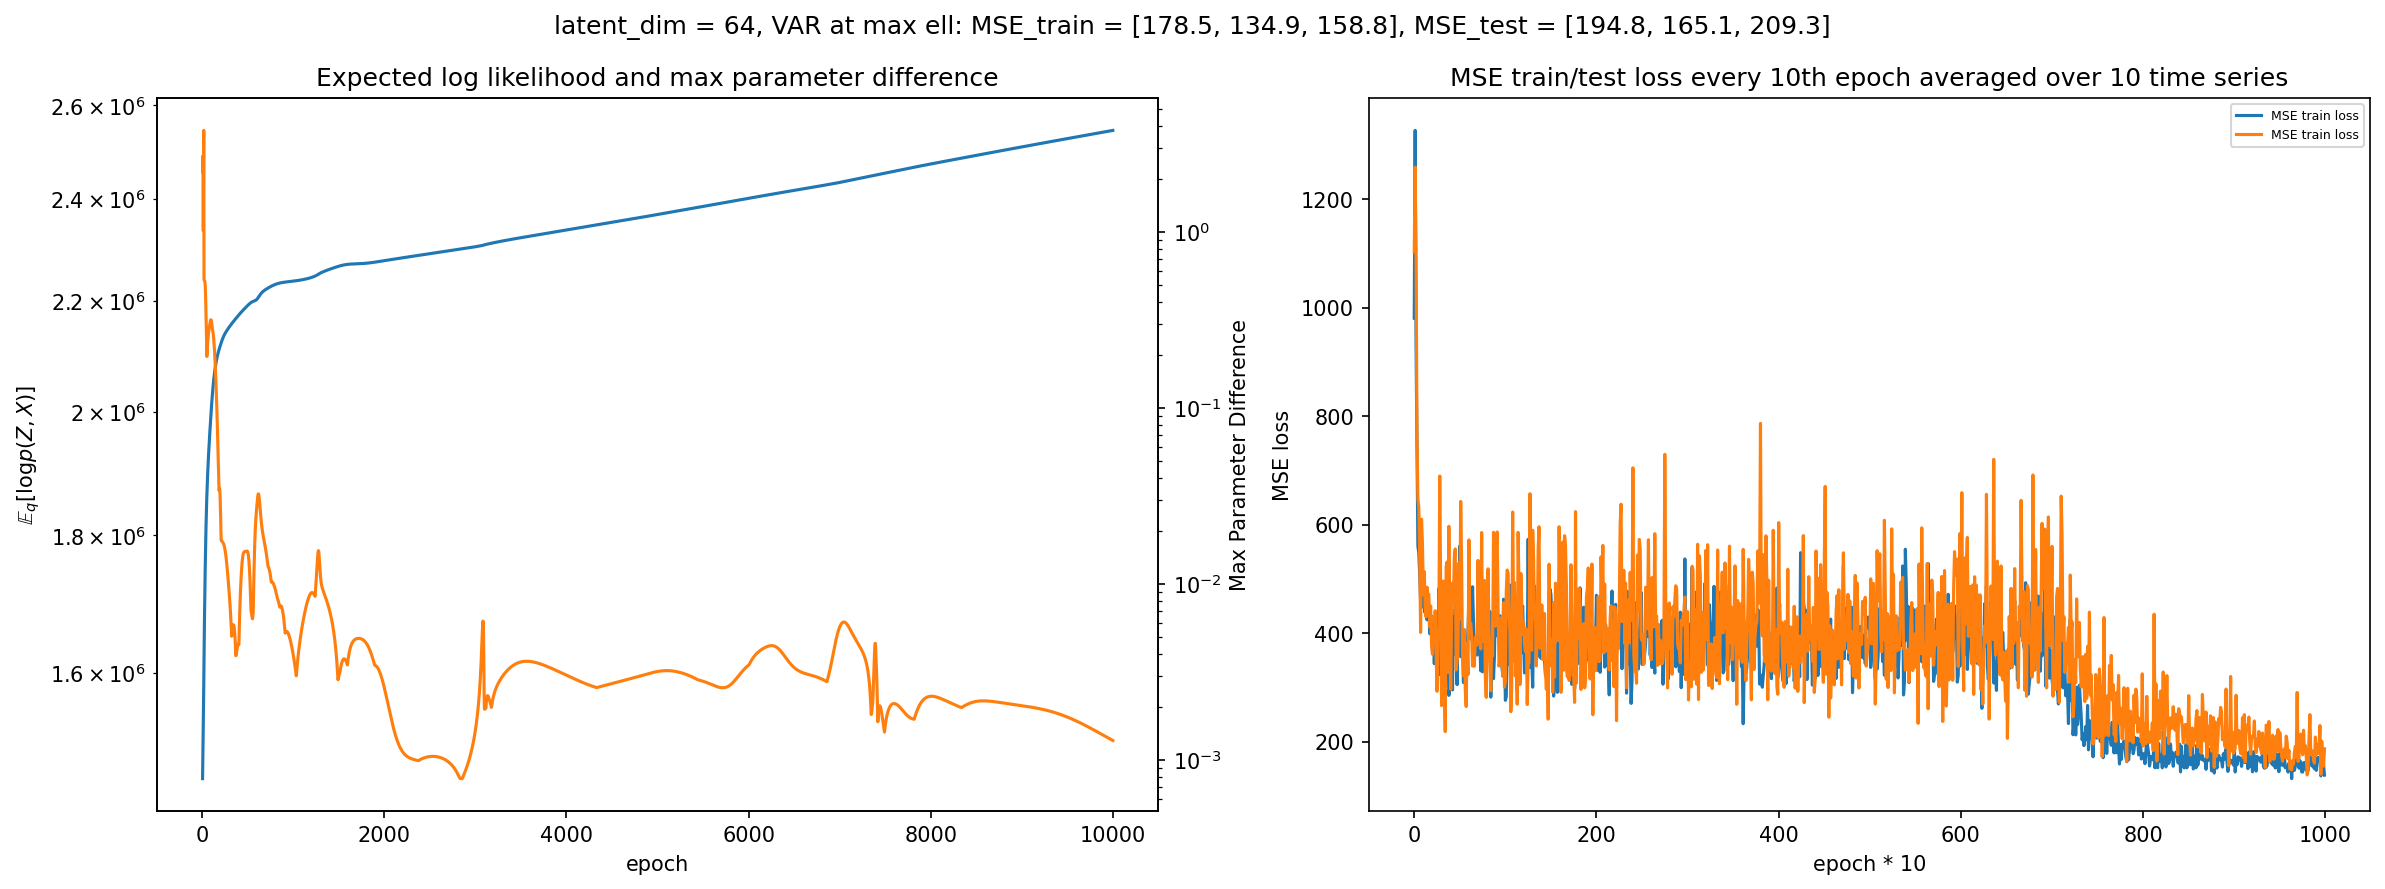

In [35]:
for latent_dim in [4,8,16,32,64]:
    # Load the parameters and lists, choose the model with highest expected-log-likelihood
    A_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy")
    Sigma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy")
    mu0_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy")
    B_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy")
    Gamma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy")
    expected_log_likelihoods = np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy")
    parameter_differences = np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy")
    MSE_train = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy")
    MSE_test = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy")
    index = np.argmax(expected_log_likelihoods)
    
    # Plot the expected-log-likelihood and the parameter differences on the left side
    # and the MSE_train and MSE_test on the right side
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    ax1 = axes[0]
    ax2 = ax1.twinx()
    start = 5
    ax1.plot(np.arange(start, len(expected_log_likelihoods)), expected_log_likelihoods[start:], 'C0')
    ax2.plot(np.arange(start, len(expected_log_likelihoods)), parameter_differences[start:], 'C1')
    ax1.set_xlabel("epoch")
    ax1.set_ylabel(r"$\mathbb{E}_q[\log p(Z,X)]$")
    ax2.set_ylabel("Max Parameter Difference")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_title("Expected log likelihood and max parameter difference")

    axes[1].plot(MSE_train, label="MSE train loss")
    axes[1].plot(MSE_test, label="MSE train loss")
    axes[1].set_xlabel("epoch * 10")
    axes[1].set_ylabel("MSE loss")
    axes[1].set_title("MSE train/test loss every 10th epoch averaged over 10 time series")
    axes[1].legend()
    
    
    # Calculate 1000 time series using the best VAR, calculate the MSE-error for the training set and test set
    # and add them to the title
    var = VAR(A_params[index], Sigma_params[index], mu0_params[index], B_params[index], Gamma_params[index])
    generated_time_series = np.array([var.generate_time_series(len(npa))[1] for _ in range(1000)])
    generated_time_series_train = generated_time_series[:, :len(x_train), :]
    generated_time_series_test = generated_time_series[:, len(x_train):, :]
    train_error = ", ".join([str(n) for n in np.round(((generated_time_series_train - x_train[np.newaxis,:,:])**2).mean(axis=1).mean(axis=0), 1)])
    test_error = ", ".join([str(n) for n in np.round(((generated_time_series_test - x_test[np.newaxis,:,:])**2).mean(axis=1).mean(axis=0), 1)])
    
    plt.suptitle(f"latent_dim = {latent_dim}, VAR at max ell: MSE_train = [{train_error}], MSE_test = [{test_error}]")
    
    plt.tight_layout()
    plt.show()
    
    

In the plots, we can see that the MSE-losses for the latent-dimensions 4, 8 and 16 are fluctuating around 400, while the MSE-losses of the VARs with 32 and 64 dimensions start to decrease again after $\sim7500$ iterations and converge to $\sim150-200$. Due to the high number of iterations needed and the high duration of the iteration, we are not able to further increase the latent dimension. Since the MSE-loss for the 64-dimensional VAR is slightly lower than the MSE-loss of the 32-dimensional VAR, we use this model in the following.

In [13]:
# load the best model and save the parameters again as a dict.
latent_dim = 64
A_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy")
Sigma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy")
mu0_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy")
B_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy")
Gamma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy")
expected_log_likelihoods = np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy")
parameter_differences = np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy")
MSE_train = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy")
MSE_test = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy")
index = np.argmax(expected_log_likelihoods)

optimal_params = {
    "A": A_params[index],
    "Sigma": Sigma_params[index],
    "mu0": mu0_params[index],
    "B": B_params[index],
    "Gamma": Gamma_params[index]
}
np.save("VAR_optimal_params.npy", optimal_params)

In [44]:
var_optimal = VAR.load_from_dict("VAR_optimal_params.npy")

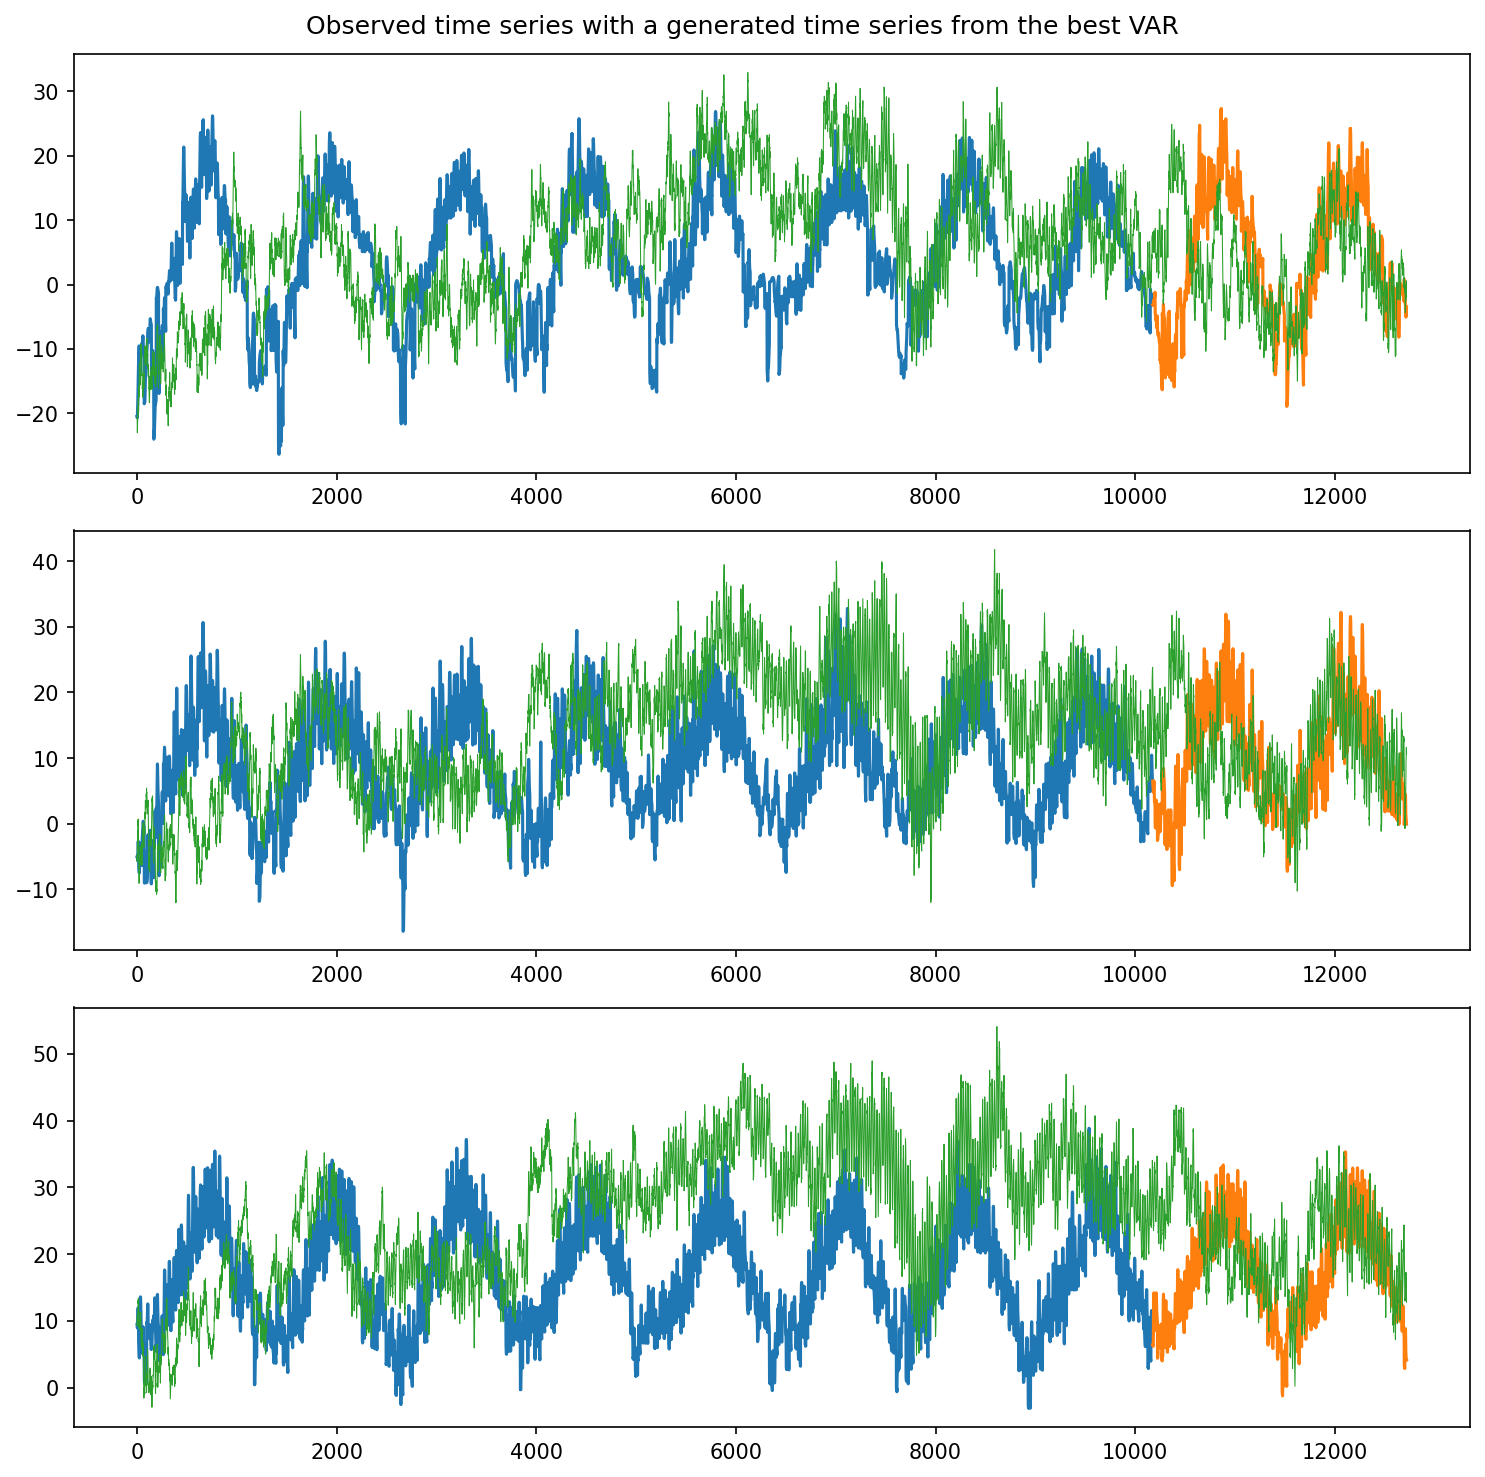

In [52]:
ts = var_optimal.generate_time_series(len(npa))[1]

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t_train = np.arange(len(x_train))
t_test = np.arange(len(x_train), len(x_train)+len(x_test))
for i in range(3):
    axes[i].plot(t_train, x_train[:,i], c="C0")
    axes[i].plot(t_test, x_test[:,i], c="C1")
    axes[i].plot(ts[:,i], c=f"C2", lw=.5)
plt.suptitle("Observed time series with a generated time series from the best VAR")
plt.tight_layout()
plt.show()

From this example plot, one can see, that in some regions, the generated time series is close to the true values, while in other regions it deviates more strongly and does not predict the true values.

In [46]:
# The VAR starts from z0 by sampling with mu0. In order to begin from any point in the training series, we need a suitible
# mu for that point. One could sample a z0 using mu0, iterate until that point and use the last z as new starting point.
# But the quality of the predictions heavily depend on the sampled z0. Sampling multiple z0s and iterate all of them 
# and average the resulting zs would not work, since they might differ.
# Instead, we perform the Kalman-Filter-Smoother once using the optimal parameters and choose
# mu_tilde[t] as initial mean of the latent state.
def draw_initial_conditions(var, num):
    T = len(x_train)
    _, _, mu_tilde, _, _ = Kalman_Filter_Smoother(x_train, L0=var.Sigma, **var.get_parameters())
    initial_time_points = np.random.choice(np.arange(T), size=num, replace=False)
    return initial_time_points, mu_tilde[initial_time_points]

(2544, 3)


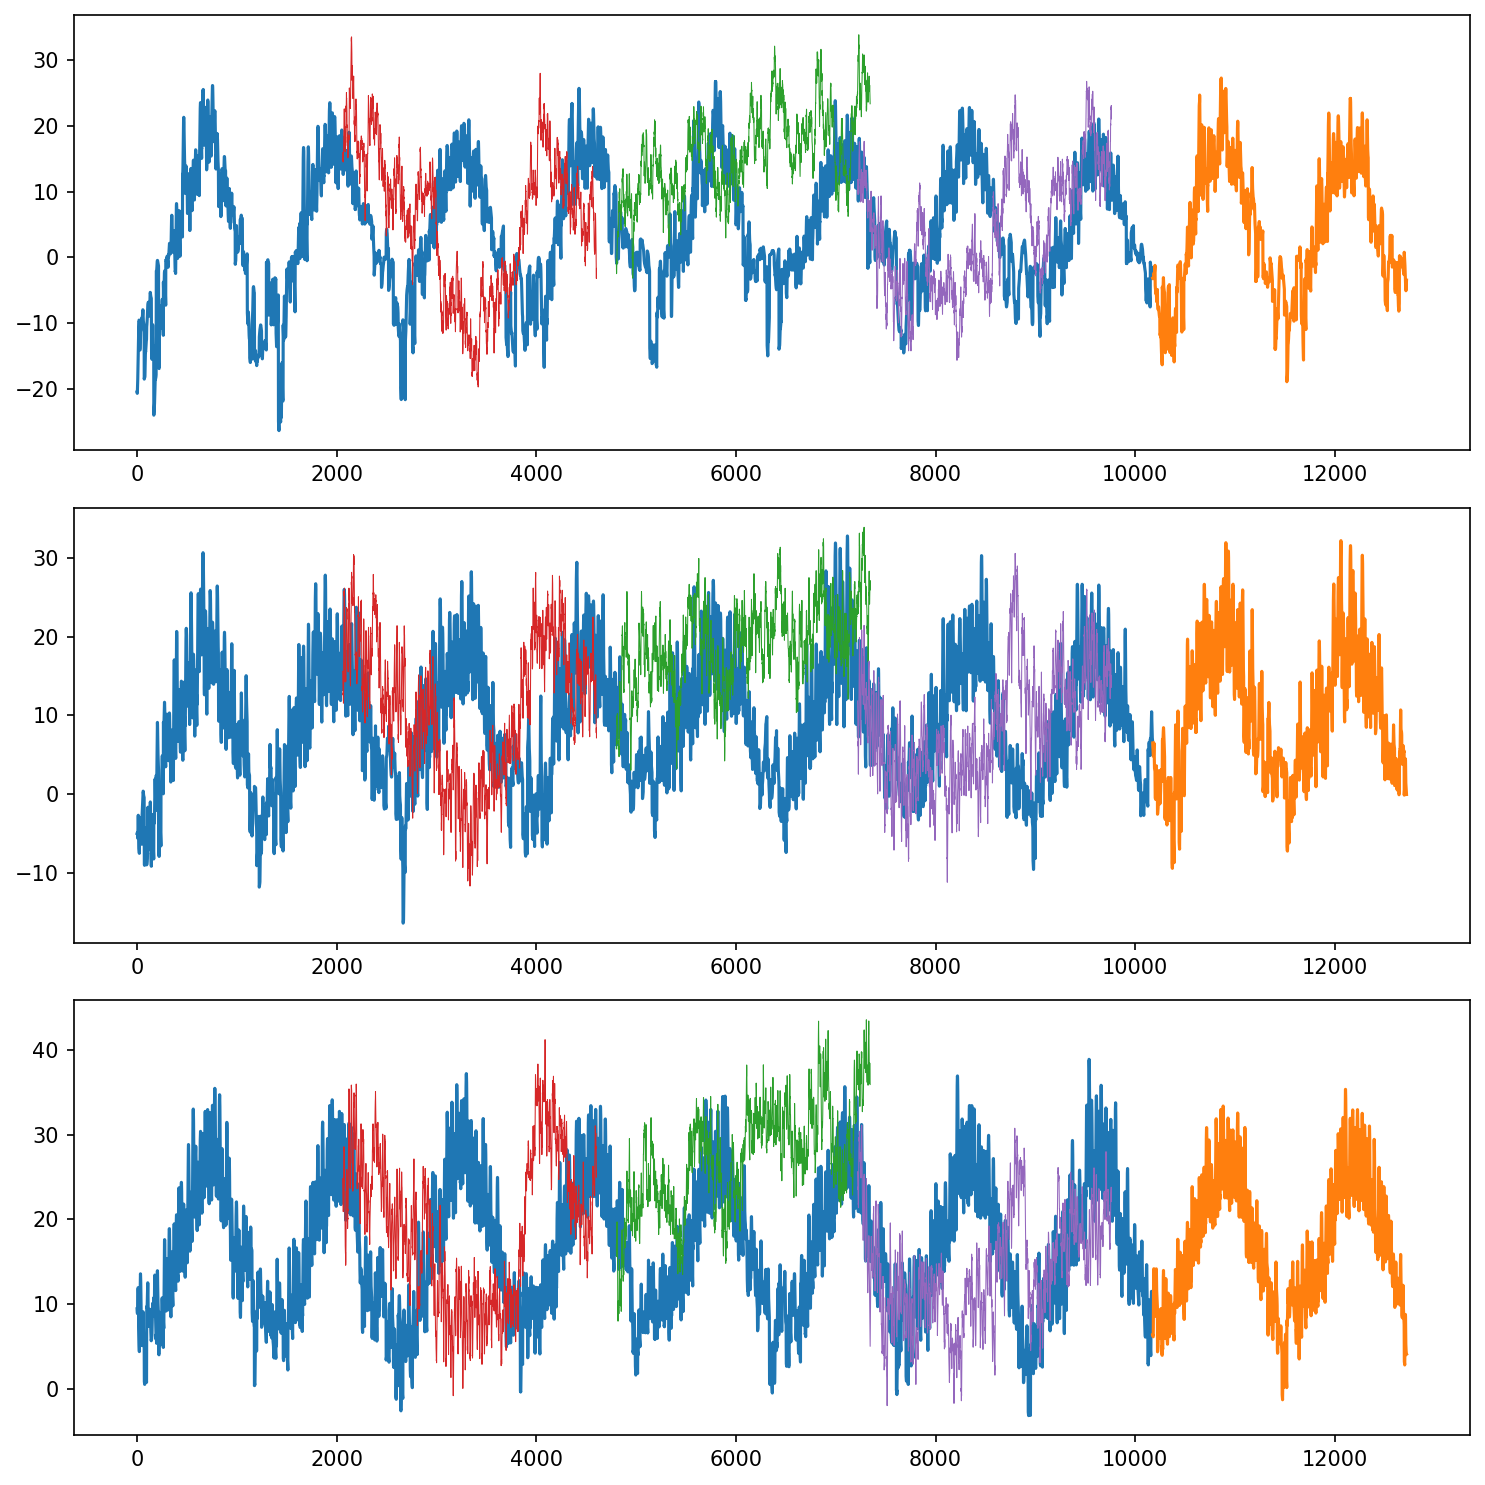

In [47]:
initial_time_points, mu0s = draw_initial_conditions(var_optimal, 3)
time_series_length = len(x_train)//4
generated_time_series = [var_optimal.generate_time_series(time_series_length, mu0=mu0)[1] for mu0 in mu0s]
print(generated_time_series[0].shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t_train = np.arange(len(x_train))
t_test = np.arange(len(x_train), len(x_train)+len(x_test))
for i in range(3):
    axes[i].plot(t_train, x_train[:,i], c="C0")
    axes[i].plot(t_test, x_test[:,i], c="C1")
    for j in range(len(generated_time_series)):
        axes[i].plot(np.arange(initial_time_points[j], initial_time_points[j]+time_series_length), generated_time_series[j][:,i], c=f"C{j+2}", lw=.5)
plt.tight_layout()
plt.show()